## Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [4]:
# library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn import metrics

In [5]:
data  = pd.read_csv('chronic_kidney_disease_full.csv')

In [6]:
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [7]:
data.shape

(400, 25)

In [8]:
data.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

In [9]:
data.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

In [11]:
# Answer here: Age, blood pressure, and diabetes mellitus are important factors that might contribute to the cause of CKD.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [13]:
data.isnull().sum()[data.isnull().sum()!=0]

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

In [14]:
# The rbc, wbcc, and rbcc columns have too many missing values. 
# In this case, we should drop these features to avoid losing a significant number of observations. 
# Imputing them is not ideal, as it could likely lead to overfitting.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [16]:
# Answer here:
# 1. Loss of too much information, leading to increased bias.
# 2. Decreased statistical power, which will impact future predictions.

In [17]:
# Set our target
# 0 = Not CKD
# 1 = CKD
data['class'] = data['class'].map({'notckd':0,'ckd':1})

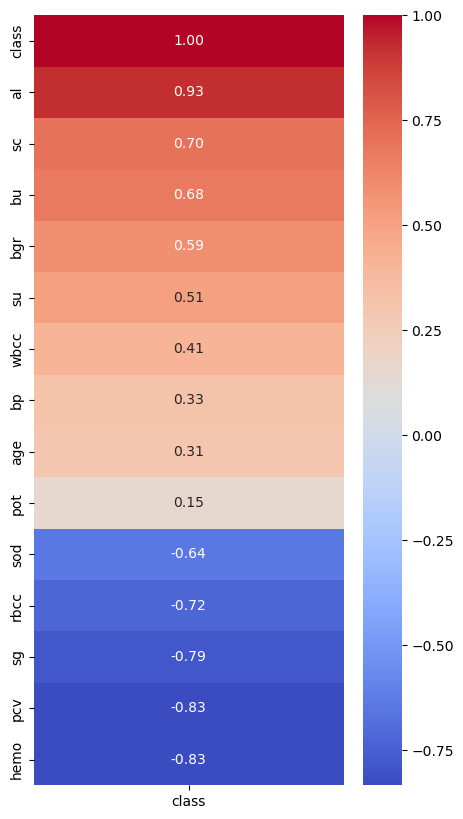

In [18]:
# Check correlation between numeric column and class
numeric = data.copy()
numeric.dropna(inplace = True)
numeric = numeric.select_dtypes(exclude = 'object')
correlation_with_class = numeric.corr()[['class']].sort_values(by='class', ascending=False)

plt.figure(figsize=(5, 10))  
sns.heatmap(correlation_with_class, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.show()

In [19]:
# Potassium has a correlation of only 0.15 with the target variable class, 
# and the distribution of potassium levels is similar across both classes. Therefore, we can consider dropping it.

In [20]:
data[data['class'] == 0]['pot'].unique()

array([5. , 4.6, 4.4, 4.7, 3.7, 3.9, 3.5, 3.8, 3.6, 4.1, 4.5, 4.8, 4.9,
       4. , 4.2, nan, 4.3, 3.3])

In [21]:
data[data['class'] == 1]['pot'].unique()

array([ nan,  2.5,  3.2,  4. ,  3.7,  4.2,  5.8,  3.4,  6.4,  4.9,  4.1,
        4.3,  5.2,  3.8,  4.6,  3.9,  4.7,  5.9,  4.8,  4.4,  6.6, 39. ,
        5.5,  5. ,  3.5,  3.6,  7.6,  2.9,  4.5,  5.7,  5.4,  5.3, 47. ,
        6.3,  5.1,  5.6,  3. ,  2.8,  2.7,  6.5,  3.3])

In [22]:
# drop too many missing value ---> rbc, wbcc, rbcc
# drop least correlation and many missing value ---> pot
data.drop(columns = ['pot', 'rbc', 'wbcc', 'rbcc'], inplace = True)

In [23]:
data.isnull().sum()[data.isnull().sum()!=0]

age       9
bp       12
sg       47
al       46
su       49
pc       65
pcc       4
ba        4
bgr      44
bu       19
sc       17
sod      87
hemo     52
pcv      71
htn       2
dm        2
cad       2
appet     1
pe        1
ane       1
dtype: int64

In [24]:
def impute(data):
    for column in data.select_dtypes(exclude='object').columns:
        # Check if the column is skewed
        skewness = data[column].skew()
        
        # Choose imputation method based on skewness
        if -0.5 < skewness < 0.5:
            # If skew is low, impute with the mean
            data[column] = data[column].fillna(data[column].mean())
        else:
            # If skew is high, impute with the median
            data[column] = data[column].fillna(data[column].median())
    
    return data

data = impute(data)

In [25]:
# object column still have missing value 
data.isnull().sum()[data.isnull().sum()!=0]

pc       65
pcc       4
ba        4
htn       2
dm        2
cad       2
appet     1
pe        1
ane       1
dtype: int64

In [26]:
# drop all missing value in object columns
data.dropna(inplace = True)

In [27]:
# 329 from 400, we having ~82% of data after clean
data.shape

(329, 21)

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

In [29]:
# Answer here:
# 1. The data might contain entry errors due to manual input.
# 2. Records may be prone to diagnostic inaccuracies, especially if handled by interns or less experienced staff.
# 3. Patient charts could be mixed up, leading to information being recorded in the wrong file.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

In [31]:
# Answer here:
# Always predict “CKD” for every person, regardless of their actual condition.
# Guarantees  no individual with CKD will ever be missed.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

In [33]:
# Answer here:
# Minimizes false negatives to zero,
# but does not minimize false positives; instead, it increases them

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

In [35]:
# Answer here:
# Patients who don't have CKD but are told they do may experience unnecessary anxiety and stress.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

In [37]:
# Answer here:
# Always predict “No CKD” for every person, regardless of their actual condition.
# Guarantees that no individual without CKD will ever be told they have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

In [39]:
# Answer here:
# Minimizes false positives to zero ,
# but does not minimize false negatives ; instead, it increases them

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

In [41]:
# Answer here:
# Patients who have CKD but are told they don’t may experience worsening symptoms.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [43]:
object  = list(set(data.select_dtypes(include='object').columns) - {'class'})

In [44]:
data = pd.get_dummies(data= data ,columns = object)

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [46]:
data['class'].value_counts(normalize=True)

class
1    0.589666
0    0.410334
Name: proportion, dtype: float64

In [47]:
X = data.drop(columns = 'class')
y = data['class']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42, train_size=0.70)

In [134]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230, 29), (99, 29), (230,), (99,))

In [136]:
y_train.value_counts(normalize=True)

class
1    0.591304
0    0.408696
Name: proportion, dtype: float64

In [138]:
y_test.value_counts(normalize=True)

class
1    0.585859
0    0.414141
Name: proportion, dtype: float64

In [140]:
y_test.value_counts()

class
1    58
0    41
Name: count, dtype: int64

In [142]:
# Scale Features
sc = StandardScaler() # Transformer
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [144]:
logreg = LogisticRegression()
logreg.fit(X_train_sc,y_train)

LogisticRegression()

In [146]:
cross_val_score(logreg, X_train_sc, y_train, cv = 5).mean()

0.9913043478260869

In [147]:
y_preds = logreg.predict(X_test_sc)

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [151]:
coef_list = pd.DataFrame({
    'feature': X.columns,
    'coef': logreg.coef_[0]  
})

# Sort the coefficients by 'coef' in descending order
coef_list.sort_values(by='coef', ascending=False).head(1)

,feature,coef
3,al,1.166417


### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: 
1. Logistic regression provides clear and interpretable results
2. Logistic regression is computationally efficient and easy to implement

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why?

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [156]:
# Yes, it makes sense to generate a confusion matrix, but it should be done on the test data. 
# The concept behind model training is to use the training data to predict outcomes on unseen test data. 
# The confusion matrix reflects the quality of these predictions.

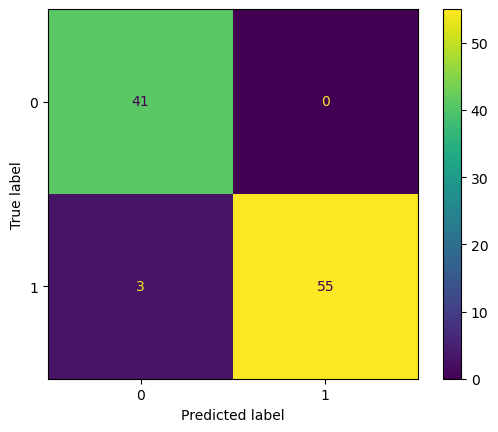

In [158]:
cm = metrics.confusion_matrix(y_test, y_preds)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_).plot();

In [160]:
print(metrics.classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       1.00      0.95      0.97        58

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

In [163]:
# Answer: Recall is the most important metric that should be optimized to reduce the number of patients
# with CKD who are incorrectly told they do not have it. 
# A misdiagnosis can have a significant impact on their lives, potentially leading to death.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

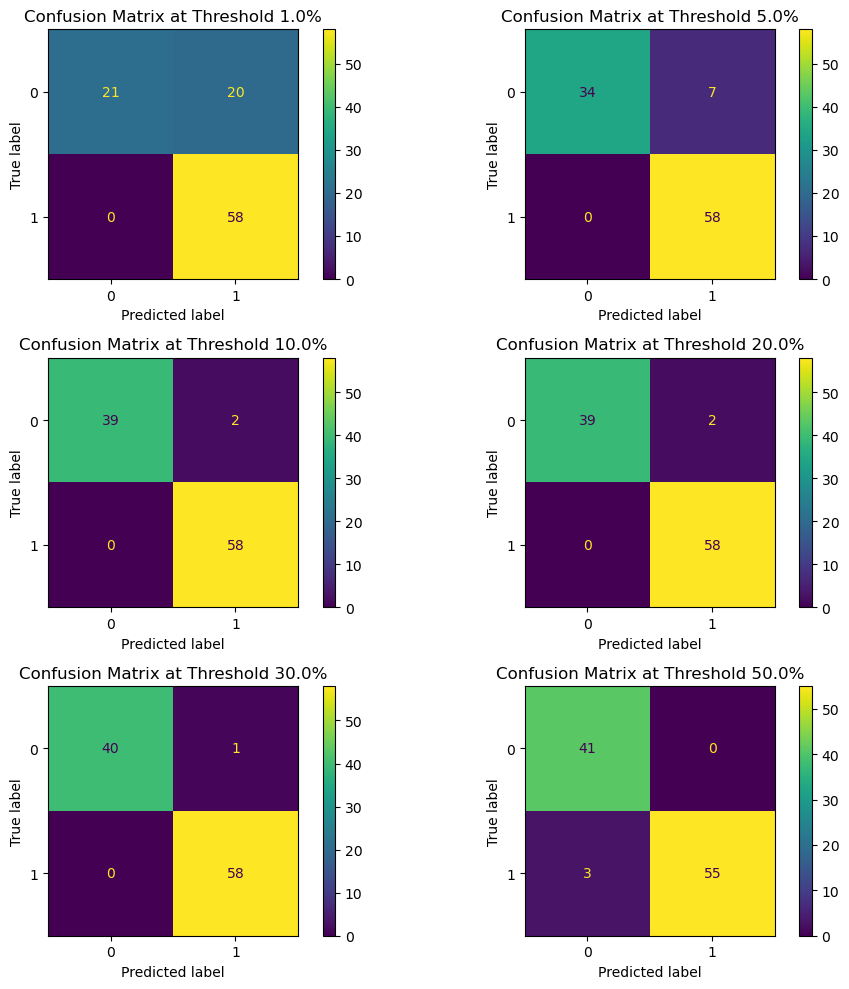

In [170]:
y_pp = pd.DataFrame(logreg.predict_proba(X_test_sc), columns=['class_0', 'class_1'])

thresholds = [0.01, 0.05, 0.1, 0.20, 0.30, 0.50]
for threshold in thresholds:
    y_pp[f'preds_threshold_{threshold}'] = (y_pp['class_1'] >= threshold).astype(int)

# Set up the subplot grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 3 rows, 2 columns
axes = axes.flatten() 

# Generate confusion matrices for each threshold and plot them
for i, threshold in enumerate(thresholds):
    preds_column = f'preds_threshold_{threshold}'
    cm = metrics.confusion_matrix(y_test, y_pp[preds_column])
    
    # Display confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
    disp.plot(ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix at Threshold {threshold*100}%')

plt.tight_layout() 
plt.show()


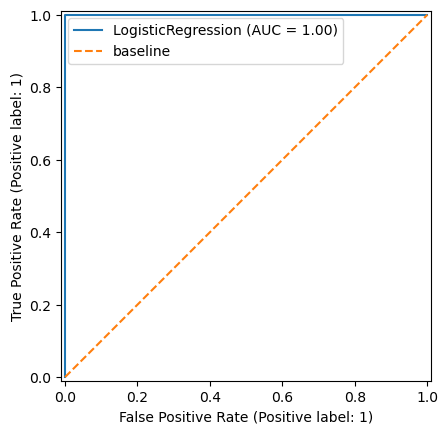

In [172]:
metrics.RocCurveDisplay.from_estimator(logreg, X_test_sc,y_test);
plt.plot([0,1],[0,1],label = 'baseline', linestyle = '--')
plt.legend();

In [174]:
metrics.roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:, 1])

1.0

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: 
**The model is likely to predict the majority class**, which means it might show high accuracy simply by predicting that no one has CKD. However, this approach fails to correctly identify the minority class.

This is indeed a problem, as **it could lead to missed CKD cases** (false negatives). If CKD cases are less common than non-CKD cases in our data, the unbalanced class distribution could result in fewer CKD cases being detected by the model.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: After diagnosis, only a small percentage of patients have the disease. So, when we gather all this information into the model, **the majority of patients are healthy**, with only a minority having the disease. This unbalanced class setup often causes the model to quickly judge most patients as healthy. As a result, the **model becomes biased** and, when predicting new patients, is **more likely to predict them as healthy** as well.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [176]:
major_class = data[data['class'] == 1]

sample = major_class.sample(n=200000, replace=True, random_state=42)

# Combine the original data with the bootstrapped sample
new_data = pd.concat([data, sample])

new_class_distribution = new_data['class'].value_counts(normalize=True)

X_new = new_data.drop(columns='class')
y_new = new_data['class']

new_data.shape, new_class_distribution

((200329, 30),
 class
 1    0.999326
 0    0.000674
 Name: proportion, dtype: float64)

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

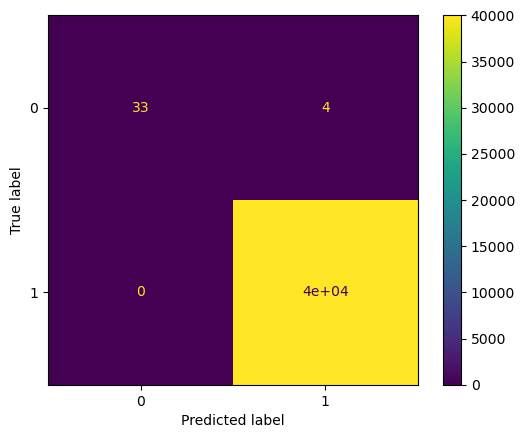

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

sc = StandardScaler() # Transformer
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_sc,y_train)

y_preds = logreg.predict(X_test_sc)

cm = metrics.confusion_matrix(y_test, y_preds)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_).plot();

In [78]:
# Before adding samples: We had 35 patients without CKD.
# After adding samples: We have only 8 patients without CKD.
# This example shows how the model treats unbalanced classes; it is more likely to be biased toward predicting the majority class.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

I would present the model to stakeholders, emphasizing how it reduces false positives and false negatives, thereby improving CKD diagnosis accuracy. By showcasing key metrics, I would demonstrate its effectiveness compared to traditional methods. The next step would be to integrate the model into the hospital’s workflow, with ongoing monitoring to ensure its continued accuracy and further enhance patient outcomes.